In [12]:
import sys
from pathlib import Path

# Notebook is in verf/ttv → parent is verf
VERF_DIR = Path.cwd().parent
sys.path.insert(0, str(VERF_DIR))

print("Project root added to sys.path:", VERF_DIR)

Project root added to sys.path: /home/adhyeta/0zProject/verf


In [13]:
VERF_DIR

PosixPath('/home/adhyeta/0zProject/verf')

In [14]:
import os
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc


In [15]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [17]:
from ttv.config import CFG
from ttv.models import SiameseFusion


In [19]:

# Adjust this if your notebook is not in verf/
DATA_DIR = VERF_DIR / "processed_tensors"
TEST_IDS_PATH = VERF_DIR / "ttv" / "test_subjects-251214_1500.txt"
# Checkpoint path (edit)
CKPT_PATH = VERF_DIR / "ttv" / "best_gait_model-251214_1500.pth"  # example
DATA_DIR,TEST_IDS_PATH,CKPT_PATH

(PosixPath('/home/adhyeta/0zProject/verf/processed_tensors'),
 PosixPath('/home/adhyeta/0zProject/verf/ttv/test_subjects-251214_1500.txt'),
 PosixPath('/home/adhyeta/0zProject/verf/ttv/best_gait_model-251214_1500.pth'))

In [20]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [21]:
test_ids = [line.strip() for line in TEST_IDS_PATH.read_text().splitlines() if line.strip()]
len(test_ids), test_ids[:5]

(14, ['S023', 'S012', 'S173', 'S035', 'S028'])

In [22]:
# Update these imports to your current package layout
model = SiameseFusion(cfg=CFG).to(DEVICE)
model.eval()

raw = torch.load(str(CKPT_PATH), map_location=DEVICE)
state_dict = raw["model_state_dict"] if isinstance(raw, dict) and "model_state_dict" in raw else raw

# Optional: handle older key rename .cnn -> .net (only if needed)
if any(".cnn." in k for k in state_dict.keys()):
    state_dict = {k.replace(".cnn.", ".net."): v for k, v in state_dict.items()}

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", len(missing))
print("Unexpected keys:", len(unexpected))


Missing keys: 0
Unexpected keys: 0


In [23]:
SENSORS = list(CFG.streams)
WINDOW_SIZE = CFG.window_size
STRIDE = CFG.stride  # for evaluation windows; you can set a bigger stride for fewer windows

def load_subject_tensor(subj_id: str):
    path = DATA_DIR / f"{subj_id}.pt"
    return torch.load(str(path), map_location="cpu")

test_data = {sid: load_subject_tensor(sid) for sid in test_ids}
len(test_data), list(test_data.keys())[:3]


(14, ['S023', 'S012', 'S173'])

In [24]:
@torch.no_grad()
def embed_windows_for_subject(subj_id: str, max_windows: int | None = None, stride: int = STRIDE):
    d = test_data[subj_id]
    n_points = len(d[SENSORS[0]])  # assumes all sensors same length
    starts = list(range(0, max(0, n_points - WINDOW_SIZE + 1), stride))
    if max_windows is not None and len(starts) > max_windows:
        starts = random.sample(starts, max_windows)

    embs = []
    for s in starts:
        window = {}
        for sensor in SENSORS:
            full_signal = d[sensor]                       # [T, C] or similar
            slice_tc = full_signal[s:s+WINDOW_SIZE]       # [W, C]
            # Training did: permute(1,0) to [C, W]
            window[sensor] = slice_tc.float().permute(1, 0).unsqueeze(0).to(DEVICE)

        # SiameseFusion.backbone expects dicts; easiest is to call the backbone directly if exposed
        # If not exposed, you can pass the same dict into model.backbone as in your models.py.
        emb = model.backbone(window)  # shape [1, D]

        # NORMALISE onto unit hypersphere
        emb = F.normalize(emb, p=2, dim=1)  # [1, D], ||emb||2 = 1
        embs.append(emb.squeeze(0).cpu())

    if len(embs) == 0:
        return torch.empty((0, 64))  # adjust D if yours differs
    return torch.stack(embs, dim=0)  # [N, D]

# Compute embeddings per subject
MAX_WINDOWS_PER_SUBJ = 50  # keep manageable; increase if you want
emb_by_subj = {sid: embed_windows_for_subject(sid, max_windows=MAX_WINDOWS_PER_SUBJ) for sid in test_ids}

# Quick sanity
{k: v.shape for k, v in list(emb_by_subj.items())[:3]}


{'S023': torch.Size([50, 64]),
 'S012': torch.Size([50, 64]),
 'S173': torch.Size([50, 64])}

In [25]:
def sample_genuine_pairs(embs: torch.Tensor, n_pairs: int):
    # embs: [N, D]
    N = embs.shape[0]
    if N < 2:
        return []
    pairs = []
    for _ in range(n_pairs):
        i, j = np.random.choice(N, size=2, replace=False)
        pairs.append((embs[i], embs[j]))
    return pairs

def sample_impostor_pairs(emb_a: torch.Tensor, emb_b: torch.Tensor, n_pairs: int):
    Na, Nb = emb_a.shape[0], emb_b.shape[0]
    if Na == 0 or Nb == 0:
        return []
    pairs = []
    for _ in range(n_pairs):
        i = np.random.randint(0, Na)
        j = np.random.randint(0, Nb)
        pairs.append((emb_a[i], emb_b[j]))
    return pairs

def cosine_score(u: torch.Tensor, v: torch.Tensor) -> float:
    # both are unit-normalised => cosine = dot product
    return float(torch.dot(u, v))

GENUINE_PAIRS_PER_SUBJ = 200
IMPOSTOR_PAIRS_TOTAL = 20000

genuine_scores = []
for sid, embs in emb_by_subj.items():
    for u, v in sample_genuine_pairs(embs, GENUINE_PAIRS_PER_SUBJ):
        genuine_scores.append(cosine_score(u, v))

# sample impostors across random subject pairs
subj_list = list(emb_by_subj.keys())
impostor_scores = []
for _ in range(IMPOSTOR_PAIRS_TOTAL):
    a, b = np.random.choice(subj_list, size=2, replace=False)
    emb_a, emb_b = emb_by_subj[a], emb_by_subj[b]
    if emb_a.shape[0] == 0 or emb_b.shape[0] == 0:
        continue
    i = np.random.randint(0, emb_a.shape[0])
    j = np.random.randint(0, emb_b.shape[0])
    impostor_scores.append(cosine_score(emb_a[i], emb_b[j]))

len(genuine_scores), len(impostor_scores), (np.mean(genuine_scores), np.mean(impostor_scores))


(2800, 20000, (np.float64(0.9957991567679814), np.float64(0.9679250029176474)))

In [26]:
y_true = np.array([1]*len(genuine_scores) + [0]*len(impostor_scores))
y_score = np.array(genuine_scores + impostor_scores)

fpr, tpr, thresh = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

frr = 1 - tpr
# EER: point where FAR and FRR are closest
eer_idx = np.nanargmin(np.abs(fpr - frr))
eer = (fpr[eer_idx] + frr[eer_idx]) / 2
eer_thresh = thresh[eer_idx]

def far_at_frr(target_frr: float):
    # find threshold where FRR is just below/closest to target
    idx = np.nanargmin(np.abs(frr - target_frr))
    return fpr[idx], thresh[idx]

far_1pct, th_1pct = far_at_frr(0.01)
far_10pct, th_10pct = far_at_frr(0.10)

print(f"AUC: {roc_auc:.4f}")
print(f"EER: {eer:.4f} at threshold {eer_thresh:.4f}")
print(f"FAR@FRR=1%: {far_1pct:.4f} at threshold {th_1pct:.4f}")
print(f"FAR@FRR=10%: {far_10pct:.4f} at threshold {th_10pct:.4f}")


AUC: 0.9287
EER: 0.1513 at threshold 0.9917
FAR@FRR=1%: 0.4165 at threshold 0.9788
FAR@FRR=10%: 0.1938 at threshold 0.9897


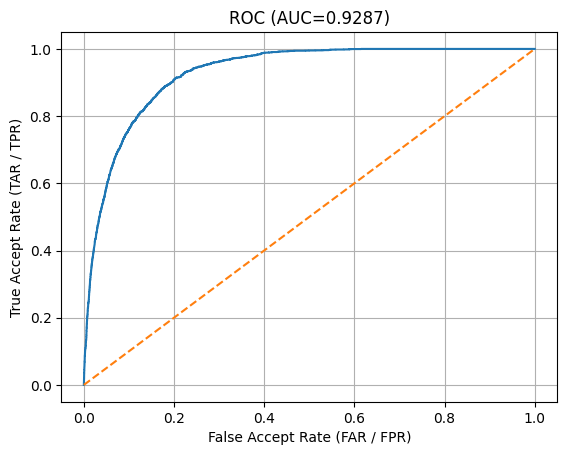

In [27]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Accept Rate (FAR / FPR)")
plt.ylabel("True Accept Rate (TAR / TPR)")
plt.title(f"ROC (AUC={roc_auc:.4f})")
plt.grid(True)
plt.show()


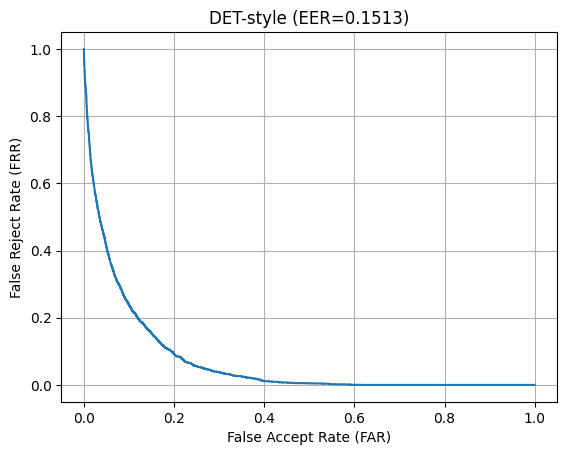

In [28]:
plt.figure()
plt.plot(fpr, frr)
plt.xlabel("False Accept Rate (FAR)")
plt.ylabel("False Reject Rate (FRR)")
plt.title(f"DET-style (EER={eer:.4f})")
plt.grid(True)
plt.show()


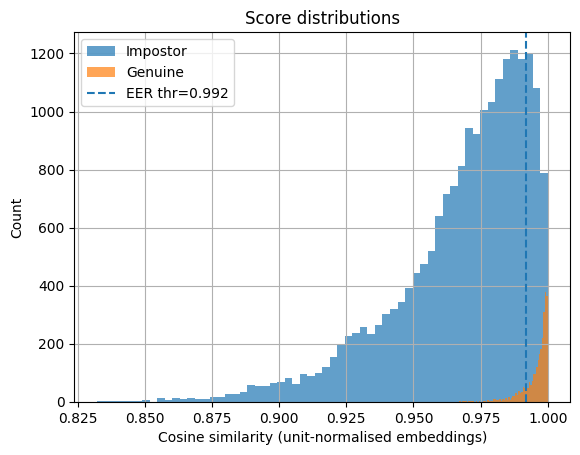

In [29]:
plt.figure()
plt.hist(impostor_scores, bins=60, alpha=0.7, label="Impostor")
plt.hist(genuine_scores, bins=60, alpha=0.7, label="Genuine")
plt.axvline(eer_thresh, linestyle="--", label=f"EER thr={eer_thresh:.3f}")
plt.xlabel("Cosine similarity (unit-normalised embeddings)")
plt.ylabel("Count")
plt.title("Score distributions")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix

def confusion_at_threshold(genuine_scores, impostor_scores, threshold):
    # Labels: 1 = genuine, 0 = impostor
    y_true = np.array([1]*len(genuine_scores) + [0]*len(impostor_scores))
    y_pred = np.array(
        [1 if s >= threshold else 0 for s in genuine_scores] +
        [1 if s >= threshold else 0 for s in impostor_scores]
    )
    return confusion_matrix(y_true, y_pred, labels=[1, 0])

cm_eer = confusion_at_threshold(genuine_scores, impostor_scores, eer_thresh)
cm_eer


array([[ 2376,   424],
       [ 3024, 16976]])

In [31]:
TP, FN = cm_eer[0]
FP, TN = cm_eer[1]

print(f"Threshold (EER): {eer_thresh:.4f}\n")
print("Confusion Matrix (Verification)")
print(f"TP (True Accept):  {TP}")
print(f"FN (False Reject): {FN}")
print(f"FP (False Accept): {FP}")
print(f"TN (True Reject):  {TN}")


Threshold (EER): 0.9917

Confusion Matrix (Verification)
TP (True Accept):  2376
FN (False Reject): 424
FP (False Accept): 3024
TN (True Reject):  16976


In [32]:
FAR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
FRR = FN / (FN + TP) if (FN + TP) > 0 else 0.0
TAR = TP / (TP + FN) if (TP + FN) > 0 else 0.0

print(f"FAR: {FAR:.4f}")
print(f"FRR: {FRR:.4f}")
print(f"TAR: {TAR:.4f}")


FAR: 0.1512
FRR: 0.1514
TAR: 0.8486


In [33]:
cm_frr1 = confusion_at_threshold(genuine_scores, impostor_scores, th_1pct)

TP, FN = cm_frr1[0]
FP, TN = cm_frr1[1]

print(f"Threshold (FRR≈1%): {th_1pct:.4f}")
print(f"FAR@FRR=1% (from CM): {FP / (FP + TN):.4f}")


Threshold (FRR≈1%): 0.9788
FAR@FRR=1% (from CM): 0.4165


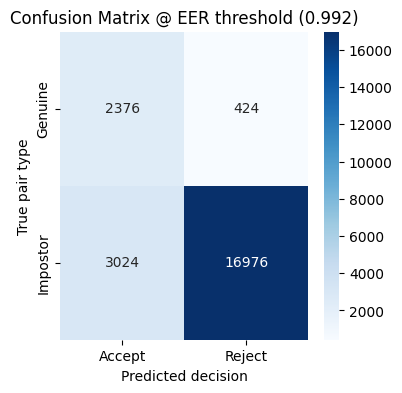

In [34]:
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_eer,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Accept", "Reject"],
    yticklabels=["Genuine", "Impostor"]
)
plt.title(f"Confusion Matrix @ EER threshold ({eer_thresh:.3f})")
plt.xlabel("Predicted decision")
plt.ylabel("True pair type")
plt.show()
